In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, TwoModels, ClassTransformation
from catboost import CatBoostClassifier

In [3]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import KBinsDiscretizer, PolynomialFeatures, PowerTransformer
from sklearn.pipeline import FeatureUnion

In [4]:
# from sklearn.preprocessing import KBinsDiscretizer


In [5]:
data = pd.read_csv('data.csv')
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [7]:
data.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)

In [8]:
data['treatment'] = data['treatment'].map(lambda a: 0 if a=='No Offer' else 1)

In [9]:
data['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [10]:
# data.drop('offer', axis=1, inplace=True)
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [11]:
indeces = data.index
indeces_train, indeces_test = train_test_split(indeces, test_size=0.3, random_state=47)

In [12]:
x_train = data.drop(['treatment', 'target'], axis=1).loc[indeces_train]
x_test = data.drop(['treatment', 'target'], axis=1).loc[indeces_test]

treat_train = data.loc[indeces_train, 'treatment']
treat_test = data.loc[indeces_test, 'treatment']

y_train = data.loc[indeces_train, 'target']
y_test = data.loc[indeces_test, 'target']

In [13]:
x_train['channel'].value_counts()

Web             19714
Phone           19659
Multichannel     5427
Name: channel, dtype: int64

In [14]:
# a = pd.get_dummies(x_train['channel'], prefix='channel')
pd.get_dummies(x_train['channel'], prefix='channel')

,channel_Multichannel,channel_Phone,channel_Web
5850,0,1,0
60101,1,0,0
61519,0,0,1
56665,0,1,0
6127,0,1,0
...,...,...,...
23112,0,1,0
11528,0,0,1
47431,0,1,0
51078,0,1,0


In [15]:
x_train['zip_code'].value_counts()

Surburban    20236
Urban        17885
Rural         6679
Name: zip_code, dtype: int64

In [16]:
a = x_train['zip_code'].map({'Rural': 1, 'Surburban': 2, 'Urban':3}, 0)
a
# x_train['zip_code'] = x_train['zip_code'].map({'Rural': 1, 'Surburban': 2, 'Urban':3}, 0)
# x_train['zip_code']

5850     3
60101    2
61519    1
56665    3
6127     2
        ..
23112    2
11528    3
47431    2
51078    1
38023    3
Name: zip_code, Length: 44800, dtype: int64

In [17]:
x_train['used_discount'].value_counts()

1    24706
0    20094
Name: used_discount, dtype: int64

In [18]:
x_train['used_bogo'].value_counts()

1    24654
0    20146
Name: used_bogo, dtype: int64

In [19]:
x_train['is_referral'].value_counts()

1    22445
0    22355
Name: is_referral, dtype: int64

<AxesSubplot:>

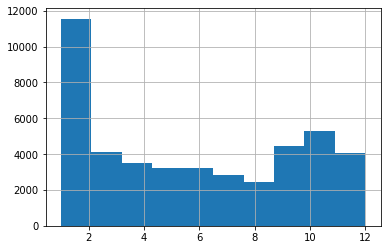

In [20]:
x_train['recency'].hist()

In [21]:
kb = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')

In [22]:
temp = kb.fit_transform(x_train[['recency']])

In [23]:
pd.DataFrame(temp).value_counts()

0.0    19220
2.0    13842
1.0    11738
dtype: int64

In [24]:
# scaler = StandardScaler()
# temp = pd.DataFrame(scaler.fit_transform(x_train[['recency']]))

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

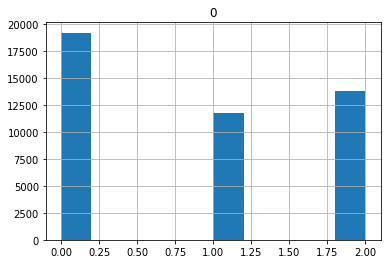

In [25]:
pd.DataFrame(temp).hist()

In [26]:
pt = PowerTransformer(method='box-cox')

In [27]:
history_log = pt.fit_transform(x_train[['history']])

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

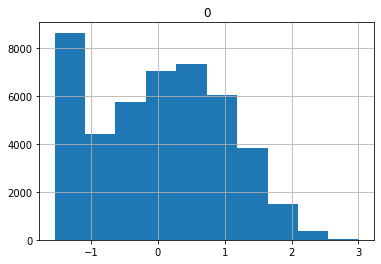

In [28]:
pd.DataFrame(history_log).hist()

In [29]:
# pd.DataFrame(history_log).describe()

In [30]:
class DataProcessing(TransformerMixin):
    
    def fit(self, X, y=None, treat=None):
        return self
    
    def transform(self, X, y=None, treat=None):
        X1 = X.copy()
        X1['zip_code'] = X1['zip_code'].map({'Rural': 1, 'Surburban': 2, 'Urban':3}, 0)
        
        dum = pd.get_dummies(X1['channel'], prefix='channel')
        X1 = pd.merge(X1, dum, left_index=True, right_index=True)
        X1 = X1.drop('channel', 1)
        
        kb = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
        X1['recency'] = kb.fit_transform(X1[['recency']])
        
        pt = PowerTransformer(method='box-cox')
        X1['history'] = pt.fit_transform(X1[['history']])
        
        pl = PolynomialFeatures(degree=2)
        new_features = pl.fit_transform(X1[['recency', 'history', 'zip_code']])
        for i in range(new_features.shape[1]):
            X1[f'{i+1}'] = new_features[:,i]
        
        return X1

In [31]:
class DataProcessing2(TransformerMixin):
    
    def fit(self, X, y=None, treat=None):
        return self
    
    def transform(self, X, y=None, treat=None):
        X1 = X.copy()
        X1['zip_code'] = X1['zip_code'].map({'Rural': 1, 'Surburban': 2, 'Urban':3}, 0)
        
        dum = pd.get_dummies(X1['channel'], prefix='channel')
        X1 = pd.merge(X1, dum, left_index=True, right_index=True)
        X1 = X1.drop('channel', 1)
        
        kb = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
        X1['recency'] = kb.fit_transform(X1[['recency']])
        
        pt = PowerTransformer(method='box-cox')
        X1['history'] = pt.fit_transform(X1[['history']])
        
#         pl = PolynomialFeatures(degree=2)
#         new_features = pl.fit_transform(X1[['recency', 'history', 'zip_code']])
#         for i in range(new_features.shape[1]):
#             X1[f'{i+1}'] = new_features[:,i]
        
        return X1

In [32]:
dp = DataProcessing()

In [33]:
x_train1 = dp.fit_transform(x_train)

In [34]:
x_test1 = dp.fit_transform(x_test)

In [35]:
# dp2 = DataProcessing2()

In [36]:
# x_train2 = dp2.fit_transform(x_train)
# x_test2 = dp2.fit_transform(x_test)

In [37]:
# b = dp.fit_transform(x_train, y_train, treat_train)

In [38]:
x_test1.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel_Multichannel,channel_Phone,channel_Web,1,2,3,4,5,6,7,8,9,10
29010,1.0,0.572118,1,0,2,0,0,1,0,1.0,1.0,0.572118,2.0,1.0,0.572118,2.0,0.327319,1.144237,4.0
28366,2.0,-1.205557,1,0,3,0,0,0,1,1.0,2.0,-1.205557,3.0,4.0,-2.411114,6.0,1.453368,-3.616671,9.0
31696,1.0,0.228723,0,1,1,0,0,0,1,1.0,1.0,0.228723,1.0,1.0,0.228723,1.0,0.052314,0.228723,1.0
58135,2.0,-0.711385,1,0,2,1,0,0,1,1.0,2.0,-0.711385,2.0,4.0,-1.422771,4.0,0.506069,-1.422771,4.0
35598,2.0,0.946792,0,1,3,1,0,1,0,1.0,2.0,0.946792,3.0,4.0,1.893583,6.0,0.896414,2.840375,9.0


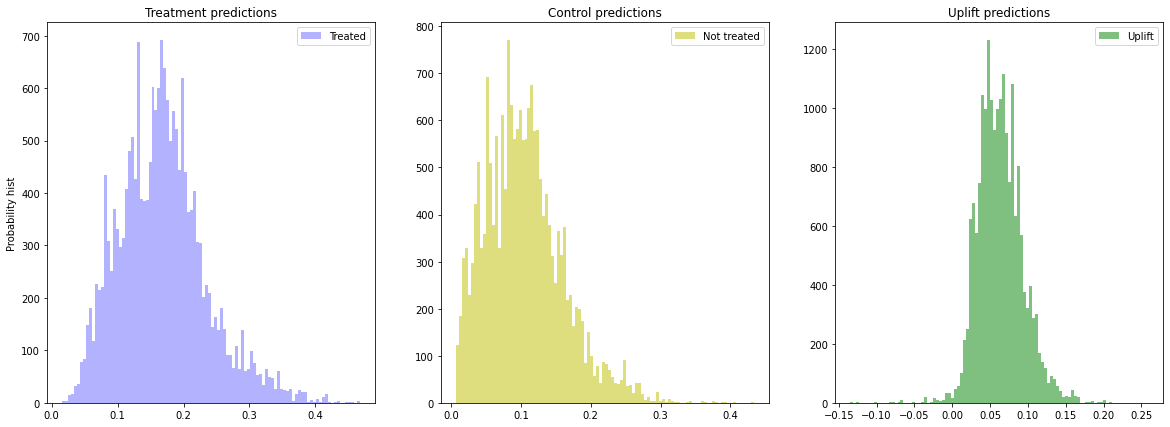

In [39]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(x_train1, y_train, treat_train)

uplift_sm = sm.predict(x_test1)

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)

models_results = {
    'approach': [],
    'uplift@30%': []
}

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [40]:
# model1 = Pipeline([('feature_processing', DataProcessing()),
#                   ('model', sm)])

In [41]:
# model1.fit(x_train, y_train, treat_train)

In [42]:
# sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
# sm = sm.fit(x_train2, y_train, treat_train)

# uplift_sm = sm.predict(x_test2)

# sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)



# # Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
# sm_trmnt_preds = sm.trmnt_preds_
# # И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
# sm_ctrl_preds = sm.ctrl_preds_

# # Отрисуем распределения вероятностей и их разность (uplift)
# plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [43]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,18.994917
1,is_referral,18.357476
2,used_bogo,7.814361
3,8,7.612758
4,9,7.173935
5,history,6.019579
6,used_discount,4.987694
7,6,4.504010
8,channel_Web,3.671351
9,5,3.547357


In [44]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(x_train1, y_train, treat_train)

uplift_ct = ct.predict(x_test1)

ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

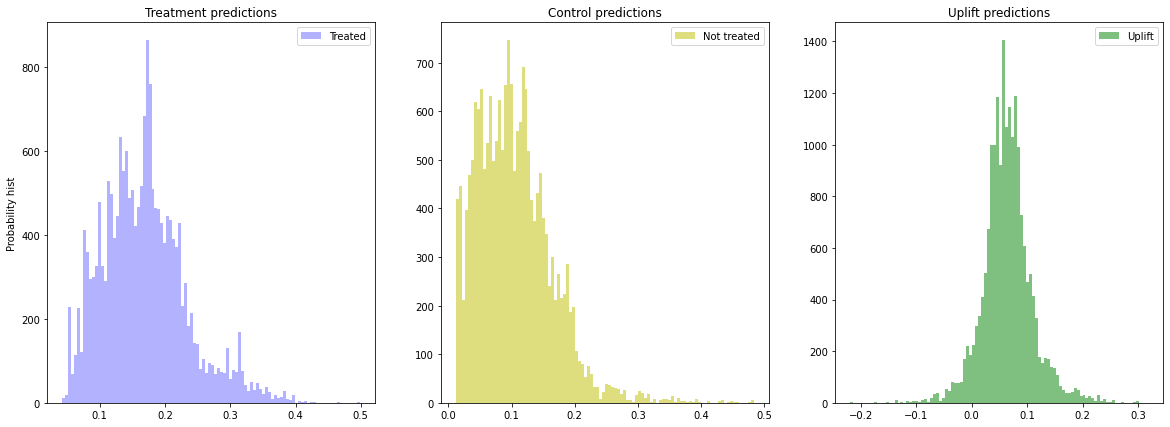

In [45]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(x_train1, y_train, treat_train)

uplift_tm = tm.predict(x_test1)

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [46]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
2,TwoModels,0.064785
0,SoloModel,0.063537
1,ClassTransformation,0.040936
